# Statistik-Projekt HS25 – Notebook 06: Konfidenzintervalle
## Ziel
Wir wollen wissen, wie präzise unsere statistischen Kennzahlen sind.
Statt nur zu sagen "Der Median der Verspätung ist 0.5 Minuten", wollen wir sagen:
"Wir sind zu 95% sicher, dass der wahre Median zwischen 0.48 und 0.52 Minuten liegt."

Da unsere Daten **nicht normalverteilt** sind (siehe N03 & N05), dürfen wir keine Standard-Formeln für Normalverteilungen verwenden.
Stattdessen nutzen wir **Bootstrapping**: Wir simulieren tausende Stichproben aus unseren eigenen Daten.

## Fragestellungen
1.  Wie gross ist das 95%-Konfidenzintervall (CI) für den Median der Verspätung?
2.  Unterscheiden sich die CI von Fernverkehr und S-Bahn? (Wenn sie sich nicht überlappen, ist das ein starkes Indiz für einen Unterschied).

## Input
* Datei: `../data/processed/istdata_clean_extended.parquet`

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 1. Konfiguration
INPUT_PATH = "../../data/processed/istdata_clean_extended.parquet"
FIG_PATH = "../reports/figures"
Path(FIG_PATH).mkdir(parents=True, exist_ok=True)

# 2. Daten laden
print(f"Lade Daten aus {INPUT_PATH}...")
df = pl.read_parquet(INPUT_PATH)

# Wichtig: Für Bootstrap brauchen wir Arrays (Numpy), das ist schneller als DataFrames
# Wir ziehen ein Sample, da Bootstrapping rechenintensiv ist (10'000 Iterationen)
sample_size = 50000
df_sample = df.sample(n=sample_size, seed=42).to_pandas()

print(f"Daten geladen. Sample-Grösse für Bootstrap: {len(df_sample)}")

Lade Daten aus ../../data/processed/istdata_clean_extended.parquet...
Daten geladen. Sample-Grösse für Bootstrap: 50000


In [2]:
def bootstrap_ci(data, metric_func, n_boot=1000, ci=95):
    """
    Berechnet das Konfidenzintervall mittels Bootstrapping.
    
    data: Array mit Daten
    metric_func: Funktion zur Berechnung der Kennzahl (z.B. np.mean oder np.median)
    n_boot: Anzahl der Bootstrap-Stichproben
    ci: Konfidenzniveau (z.B. 95 für 95%)
    """
    boot_stats = []
    n = len(data)
    
    # Bootstrap-Loop
    for _ in range(n_boot):
        # Ziehen mit Zurücklegen (replace=True)
        sample = np.random.choice(data, size=n, replace=True)
        boot_stats.append(metric_func(sample))
        
    # Perzentile berechnen
    lower = np.percentile(boot_stats, (100 - ci) / 2)
    upper = np.percentile(boot_stats, 100 - (100 - ci) / 2)
    
    return lower, upper, boot_stats

print("Bootstrap-Funktion definiert.")

Bootstrap-Funktion definiert.


Berechne Bootstrap-CI für den globalen Median...

--- Ergebnis (Global) ---
Median (Sample): 0.6167 min
95%-CI:         [0.6000, 0.6167] min


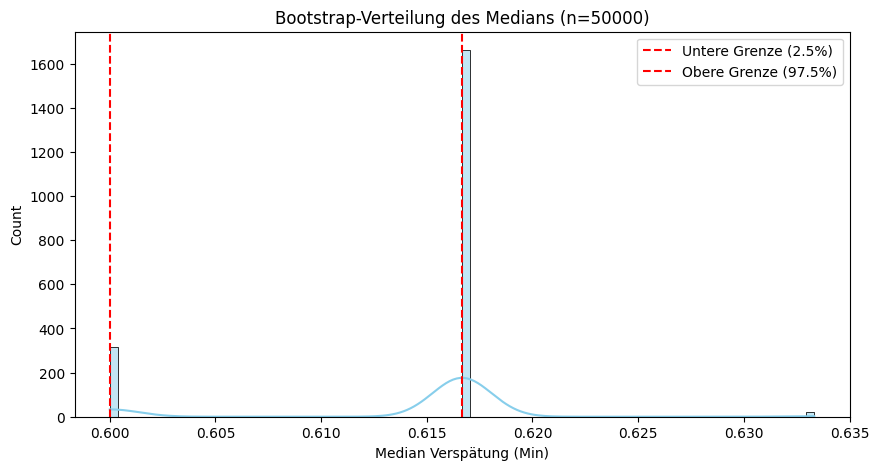

In [3]:
data_all = df_sample["arr_delay_min"].to_numpy()

print("Berechne Bootstrap-CI für den globalen Median...")
ci_lower, ci_upper, boot_dist = bootstrap_ci(data_all, np.median, n_boot=2000)

print(f"\n--- Ergebnis (Global) ---")
print(f"Median (Sample): {np.median(data_all):.4f} min")
print(f"95%-CI:         [{ci_lower:.4f}, {ci_upper:.4f}] min")

# Visualisierung der Bootstrap-Verteilung
plt.figure(figsize=(10, 5))
sns.histplot(boot_dist, kde=True, color="skyblue")
plt.axvline(ci_lower, color='red', linestyle='--', label='Untere Grenze (2.5%)')
plt.axvline(ci_upper, color='red', linestyle='--', label='Obere Grenze (97.5%)')
plt.title(f"Bootstrap-Verteilung des Medians (n={len(data_all)})")
plt.xlabel("Median Verspätung (Min)")
plt.legend()
plt.show()

Berechne CIs für Gruppen...

--- Vergleich Mittelwert (Mean) ---
Fernverkehr 95%-CI: [0.829, 1.053]
S-Bahn 95%-CI:      [0.889, 0.922]


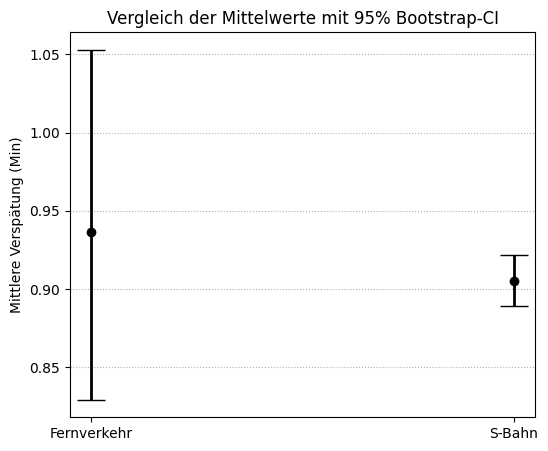

FAZIT: Die Intervalle überlappen sich.
-> Wir können (noch) nicht sicher sagen, ob ein Unterschied besteht.


In [ ]:
# Daten trennen
fv_data = df_sample[df_sample["linientyp"] == "Fernverkehr"]["arr_delay_min"].to_numpy()
sb_data = df_sample[df_sample["linientyp"] == "S-Bahn"]["arr_delay_min"].to_numpy()

print("Berechne CIs für Gruppen...")
# Wir nutzen hier den Mittelwert (Mean), da der Median oft genau auf 0 oder 1 springt bei diskreten Minuten
fv_low, fv_high, _ = bootstrap_ci(fv_data, np.mean)
sb_low, sb_high, _ = bootstrap_ci(sb_data, np.mean)

print(f"\n--- Vergleich Mittelwert (Mean) ---")
print(f"Fernverkehr 95%-CI: [{fv_low:.3f}, {fv_high:.3f}]")
print(f"S-Bahn 95%-CI:      [{sb_low:.3f}, {sb_high:.3f}]")

# Grafischer Vergleich (Error Bars)
means = [np.mean(fv_data), np.mean(sb_data)]
errors = [[means[0]-fv_low, fv_high-means[0]], [means[1]-sb_low, sb_high-means[1]]] # Abstände für Errorbar

plt.figure(figsize=(6, 5))
plt.errorbar(x=[0, 1], y=means, yerr=np.array(errors).T, fmt='o', capsize=10, linewidth=2, color='black')
plt.xticks([0, 1], ["Fernverkehr", "S-Bahn"])
plt.title("Vergleich der Mittelwerte mit 95% Bootstrap-CI")
plt.ylabel("Mittlere Verspätung (Min)")
plt.grid(axis='y', linestyle=':')
plt.show()

# Entscheidung
if fv_low > sb_high or sb_low > fv_high:
    print("FAZIT: Die Konfidenzintervalle überlappen sich NICHT.")
    print("-> Der Unterschied ist statistisch signifikant (auf dem 95% Niveau).")
else:
    print("FAZIT: Die Intervalle überlappen sich.")
    print("-> Wir können (noch) nicht sicher sagen, ob ein Unterschied besteht."../........dd.)